In [1]:
import os
import numpy as np
import scipy.io as sio
import mne
import torch
import random
from torch.utils.data import Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
from braindecode.preprocessing import exponential_moving_standardize
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from scipy.stats import ttest_1samp

python(6691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
class KARAONEDataset(Dataset):
    def __init__(self, data_root, selected_words=["pat", "pot", "knew", "gnaw"], 
                 trials_per_participant=60, transform=None, phase="speaking",
                 verbose=True):
        self.data = []
        self.labels = []
        self.transform = transform
        self.selected_words = set(selected_words)
        self.label_map = {word: i for i, word in enumerate(selected_words)}
        self.trials_per_participant = trials_per_participant
        self.participants_processed = 0
        self.phase = phase
        self.verbose = verbose
        
        self.word_counts = {word: 0 for word in selected_words}
        
        for participant_folder in os.listdir(data_root):
            participant_path = os.path.join(data_root, participant_folder)
            if not os.path.isdir(participant_path):
                continue
                
            try:
                trials_added = self._process_participant(participant_path)
                if trials_added > 0:
                    self.participants_processed += 1
                else:
                    print(f"No usable trials from {participant_folder}")
            except Exception as e:
                print(f"Skipping {participant_folder} due to error: {str(e)}")

    def _safe_get_value(self, container, key):
        value = container[key]
        if hasattr(value, 'size'):
            if value.size == 1:
                return value.item()
            else:
                return float(value.flat[0]) if value.size > 0 else 0.0
        elif hasattr(value, '__len__'):
            if len(value) == 1:
                return value[0]
            elif len(value) > 1:
                return float(value[0])
            else:
                return 0.0
        else:
            try:
                return float(value)
            except (TypeError, ValueError):
                return 0.0
        
    def _process_participant(self, participant_path):
        cnt_files = [f for f in os.listdir(participant_path) if f.endswith(".cnt")]
        if not cnt_files:
            raise FileNotFoundError(f"No .cnt file found in {participant_path}")
        
        cnt_path = os.path.join(participant_path, cnt_files[0])
        raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
        
        epoch_inds_path = os.path.join(participant_path, "epoch_inds.mat")
        if not os.path.exists(epoch_inds_path):
            raise FileNotFoundError(f"No epoch_inds.mat file found in {participant_path}")
        
        try:
            mat_data = sio.loadmat(epoch_inds_path)
            
            phase_key = f"{self.phase}_inds"
            if phase_key not in mat_data:
                available_keys = list(mat_data.keys())
                raise KeyError(f"'{phase_key}' not found in mat file. Available keys: {available_keys}")
            
            epoch_inds = mat_data[phase_key].flatten()
        except Exception as e:
            raise Exception(f"Error loading epoch_inds.mat: {str(e)}")
        
        labels_path = os.path.join(participant_path, "kinect_data", "labels.txt")
        if not os.path.exists(labels_path):
            raise FileNotFoundError(f"No labels.txt file found in {participant_path}/kinect_data/")
        
        with open(labels_path, "r") as f:
            all_labels = [line.strip().lower() for line in f]
        
        word_indices = [
            i for i, label in enumerate(all_labels)
            if label in self.selected_words
        ]
        
        valid_trials = []
        for i in word_indices:
            if i < len(epoch_inds):
                start_idx = epoch_inds[i]
                
                if hasattr(start_idx, 'size'):
                    if start_idx.size == 1:
                        start_idx = start_idx.item()
                    else:
                        start_idx = float(start_idx.flat[0])
                
                valid_trials.append((i, start_idx))
                word = all_labels[i]
                if word in self.word_counts:
                    self.word_counts[word] += 1
            elif self.verbose:
                print(f"Warning: Index {i} out of range for epoch_inds (length: {len(epoch_inds)})")
        
        if not valid_trials:
            if self.verbose:
                print(f"No valid trials found for {participant_path}")
            return 0
        
        random.shuffle(valid_trials)
        selected_trials = valid_trials[:min(self.trials_per_participant, len(valid_trials))]
        
        trials_added = 0
        for trial_idx, start_idx in selected_trials:
            sfreq = self._safe_get_value(raw.info, 'sfreq')
            
            if hasattr(start_idx, 'size'):
                if start_idx.size == 1:
                    start_idx = start_idx.item()
                else:
                    start_idx = float(start_idx.flat[0])
            
            start_idx_float = float(start_idx)
            sfreq_float = float(sfreq)
            
            tmin = start_idx_float / sfreq_float
            tmax = tmin + 1.0
            
            try:
                segment = raw.copy().crop(tmin=tmin, tmax=tmax).get_data()
                label = self.label_map[all_labels[trial_idx]]
                
                required_samples = self._safe_get_value(raw.info, 'sfreq')
                actual_samples = int(segment.shape[1])
                
                if actual_samples >= required_samples:
                    self.data.append(segment)
                    self.labels.append(label)
                    trials_added += 1
                else:
                    if self.verbose:
                        print(f"Skipping trial {trial_idx}: segment too short ({actual_samples} samples, needed {required_samples})")
            except Exception as e:
                if self.verbose:
                    print(f"Skipping trial {trial_idx} in {participant_path}")
        
        return trials_added

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [3]:
# preprocess data
def preprocess_data(X):
    X = X * 1e6
    X = exponential_moving_standardize(X, factor_new = 1e-3, init_block_size = 1000)
    return X

In [11]:
# for optimized hyperparameters
class EEGExperiment:
    def __init__(self, data_dir, epochs=15):
        self.data_dir = data_dir
        self.epochs = epochs

    def _load_data(self, seed):
        torch.manual_seed(seed)
        np.random.seed(seed)

        dataset = KARAONEDataset(self.data_dir)
        data = np.stack([preprocess_data(x) for x, _ in dataset])
        labels = np.array([y for _, y in dataset])
        return train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

    def _train_model(self, X_train, y_train, X_val, y_val, lr, batch_size):
        n_classes = 4
        n_chans, input_time_length = X_train.shape[1], X_train.shape[2]

        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length, final_conv_length='auto')
        if torch.cuda.is_available():
            model.cuda()

        clf = EEGClassifier(
            model,
            criterion=torch.nn.CrossEntropyLoss,
            optimizer=torch.optim.AdamW,
            optimizer__lr=lr,
            train_split=predefined_split(TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())),
            batch_size=batch_size,
            callbacks=[
                'accuracy',
                ('lr_scheduler', LRScheduler('CosineAnnealingLR', T_max=self.epochs - 1))
            ],
            device='cuda' if torch.cuda.is_available() else 'cpu',
            classes=list(range(n_classes))
        )

        clf.fit(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long()), y=None, epochs=self.epochs)
        return clf

    def run(self, learning_rates, batch_sizes, repeats=10):
        best_acc = 0
        best_config = None

        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(f"\nTesting config: lr = {lr}, batch_size = {batch_size}")
                X_train, X_val, y_train, y_val = self._load_data(seed = 2025)
                clf = self._train_model(X_train, y_train, X_val, y_val, lr, batch_size)
                acc = float(clf.history[-1, 'valid_accuracy'])

                print(f" → Accuracy: {acc:.4f}")
                if acc > best_acc:
                    best_acc = acc
                    best_config = {'lr': lr, 'batch_size': batch_size}

        print(f"\nBest config: {best_config}, Accuracy: {best_acc:.4f}")

        all_histories = []
        val_accuracies = []

        for i in range(repeats):
            print(f"Repeat {i+1}/{repeats}")
            X_train, X_val, y_train, y_val = self._load_data(seed = 2025 + i)
            clf = self._train_model(X_train, y_train, X_val, y_val,
                                    best_config['lr'], best_config['batch_size'])
            acc = float(clf.history[-1, 'valid_accuracy'])
            val_accuracies.append(acc)
            all_histories.append(clf.history)

        mean_acc = np.mean(val_accuracies)
        std_acc = np.std(val_accuracies)
        print(f"\nFinal result — Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

        return {
            'best_model': clf,
            'best_config': best_config,
            'all_accuracies': val_accuracies,
            'all_histories': all_histories,
            'mean_acc': mean_acc,
            'std_acc': std_acc
        }

In [12]:
data_dir = '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/KARAONE'

experiment = EEGExperiment(data_dir=data_dir, epochs=15)
results = experiment.run(
    learning_rates=[0.001, 0.0005],
    batch_sizes=[32, 64],
    repeats=10
)

print("Best hyperparameters:", results['best_config'])
print("Validation accuracies:", results['all_accuracies'])


Testing config: lr = 0.001, batch_size = 32


/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3453        2.6372       0.2500            0.2500        1.8457  0.0010  4.1016
      2            0.4065        2.0459       0.2143            0.2143        1.8492  0.0010  3.9173
      3            0.4263        1.9342       0.2214            0.2214        1.8063  0.0010  3.7120
      4            0.5468        1.6839       0.2214            0.2214        1.6850  0.0009  3.6727
      5            0.5486        1.5254       0.2286            0.2286        1.7024  0.0008  3.6336
      6            0.6241        1.4459       0.2286            0.2286        1.7534  0.0007  3.8905
      7            0.6493        1.2868       0.2357            0.2357        1.6643  0.0006  3.6375
      8            0.6853        1.3195       0.2214            0.2214        1.6871  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3022        2.8200       0.2357            0.2357        2.2431  0.0010  3.5730
      2            0.3381        2.0266       0.2714            0.2714        2.0423  0.0010  3.4420
      3            0.4047        1.9152       0.2286            0.2286        1.7191  0.0010  3.8218
      4            0.4299        1.6599       0.2500            0.2500        1.6424  0.0009  3.6287
      5            0.5270        1.6350       0.2643            0.2643        1.6079  0.0008  3.3640
      6            0.5665        1.4465       0.2786            0.2786        1.6293  0.0007  3.4623
      7            0.6097        1.4694       0.2357            0.2357        1.6300  0.0006  3.3828
      8            0.6223        1.3763       0.2500            0.2500        1.6402  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3885        2.5304       0.2857            0.2857        1.6831  0.0005  3.7153
      2            0.3957        2.1365       0.2643            0.2643        1.7127  0.0005  3.7174
      3            0.4568        1.9021       0.2500            0.2500        1.6743  0.0005  3.6808
      4            0.4856        1.7323       0.2429            0.2429        1.6360  0.0004  3.6202
      5            0.5755        1.5107       0.2214            0.2214        1.5495  0.0004  3.6670
      6            0.6223        1.5043       0.2000            0.2000        1.5681  0.0004  3.6924
      7            0.6529        1.3696       0.2429            0.2429        1.5492  0.0003  3.6923
      8            0.6799        1.3565       0.2500            0.2500        1.6200  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2788        2.4714       0.2286            0.2286        2.1468  0.0005  3.4014
      2            0.3705        2.2466       0.2571            0.2571        1.7024  0.0005  3.3760
      3            0.3993        1.8812       0.2143            0.2143        1.7327  0.0005  3.3727
      4            0.4514        1.7052       0.2429            0.2429        1.6633  0.0004  3.3803
      5            0.4640        1.7188       0.2571            0.2571        1.6769  0.0004  3.3438
      6            0.5432        1.5227       0.2786            0.2786        1.5731  0.0004  3.4043
      7            0.5827        1.4620       0.2429            0.2429        1.5792  0.0003  3.3457
      8            0.5989        1.4341       0.2571            0.2571        1.5772  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2842        2.9313       0.2429            0.2429        3.0541  0.0010  3.4195
      2            0.3849        2.1261       0.2286            0.2286        1.9212  0.0010  3.4124
      3            0.4245        1.9061       0.2643            0.2643        1.8317  0.0010  3.3908
      4            0.4910        1.7373       0.2786            0.2786        1.7640  0.0009  3.3987
      5            0.5468        1.6206       0.3071            0.3071        1.6427  0.0008  3.3696
      6            0.5809        1.4607       0.2643            0.2643        1.6613  0.0007  3.3617
      7            0.6349        1.4300       0.2929            0.2929        1.5973  0.0006  3.4255
      8            0.6673        1.2904       0.3000            0.3000        1.6223  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3022        2.7040       0.2786            0.2786        1.9485  0.0010  3.3944
      2            0.3489        2.2312       0.2214            0.2214        1.9572  0.0010  3.4790
      3            0.4442        1.9098       0.2071            0.2071        1.6863  0.0010  3.3507
      4            0.4604        1.7432       0.2500            0.2500        1.6616  0.0009  3.3890
      5            0.5162        1.6184       0.2214            0.2214        1.6678  0.0008  3.4088
      6            0.5594        1.4973       0.3000            0.3000        1.6082  0.0007  3.3985
      7            0.5899        1.5527       0.2714            0.2714        1.5991  0.0006  3.3628
      8            0.6205        1.3861       0.2643            0.2643        1.5693  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2590        2.6644       0.2500            0.2500        2.8773  0.0010  5.2959
      2            0.3255        2.2590       0.2429            0.2429        1.9937  0.0010  3.6276
      3            0.4281        1.9624       0.2214            0.2214        1.7187  0.0010  4.4567
      4            0.4550        1.6535       0.2286            0.2286        1.7280  0.0009  3.4404
      5            0.5360        1.5628       0.2143            0.2143        1.6809  0.0008  3.6337
      6            0.5917        1.4904       0.2500            0.2500        1.6359  0.0007  3.6229
      7            0.6133        1.4498       0.2357            0.2357        1.6658  0.0006  3.8126
      8            0.6403        1.3853       0.2500            0.2500        1.6604  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2842        2.6207       0.2214            0.2214        2.4127  0.0010  3.5104
      2            0.3094        2.1080       0.2286            0.2286        2.0766  0.0010  3.3887
      3            0.4119        2.0325       0.2143            0.2143        1.7261  0.0010  3.4477
      4            0.5018        1.5663       0.2000            0.2000        1.6237  0.0009  3.4118
      5            0.5072        1.4864       0.1929            0.1929        1.6887  0.0008  3.4707
      6            0.5701        1.5815       0.2143            0.2143        1.6664  0.0007  3.3814
      7            0.5863        1.3978       0.1714            0.1714        1.6949  0.0006  3.4431
      8            0.6511        1.5244       0.1929            0.1929        1.6588  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2662        3.1822       0.3000            0.3000        2.3149  0.0010  3.4299
      2            0.2878        2.8433       0.2643            0.2643        2.0203  0.0010  3.4210
      3            0.3813        2.1922       0.3071            0.3071        1.7826  0.0010  3.4003
      4            0.4245        1.9658       0.2571            0.2571        1.6033  0.0009  3.3954
      5            0.4604        1.7765       0.2714            0.2714        1.6176  0.0008  3.3684
      6            0.5000        1.6122       0.2929            0.2929        1.5538  0.0007  3.3668
      7            0.5414        1.6251       0.2500            0.2500        1.5333  0.0006  3.3769
      8            0.5773        1.4477       0.2857            0.2857        1.4869  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3129        2.7961       0.2714            0.2714        1.9875  0.0010  3.4717
      2            0.3165        2.2819       0.1929            0.1929        2.5360  0.0010  3.3678
      3            0.3975        1.9440       0.2286            0.2286        1.7624  0.0010  3.4945
      4            0.4568        1.7865       0.1857            0.1857        1.6875  0.0009  3.5184
      5            0.4928        1.6447       0.1786            0.1786        1.7136  0.0008  3.4106
      6            0.5234        1.4932       0.2214            0.2214        1.6785  0.0007  3.4011
      7            0.5809        1.4385       0.2000            0.2000        1.6095  0.0006  3.4603
      8            0.6097        1.3899       0.1857            0.1857        1.6325  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3094        2.9733       0.2643            0.2643        1.8324  0.0010  3.4295
      2            0.3561        2.3186       0.2500            0.2500        1.8640  0.0010  3.5231
      3            0.3813        2.0395       0.2214            0.2214        1.8964  0.0010  3.4044
      4            0.4478        1.7891       0.2571            0.2571        1.7510  0.0009  3.4607
      5            0.4748        1.7073       0.2286            0.2286        1.7096  0.0008  3.4248
      6            0.5378        1.6491       0.2357            0.2357        1.6527  0.0007  3.3996
      7            0.5612        1.5820       0.1929            0.1929        1.7045  0.0006  3.4617
      8            0.5971        1.4588       0.2143            0.2143        1.6961  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3147        2.9696       0.2643            0.2643        1.9980  0.0010  3.5439
      2            0.3795        2.2097       0.1857            0.1857        1.8835  0.0010  3.4819
      3            0.4263        1.7652       0.2571            0.2571        1.8355  0.0010  3.4775
      4            0.4784        1.7153       0.2357            0.2357        1.8078  0.0009  3.4187
      5            0.5270        1.6774       0.1857            0.1857        1.8438  0.0008  3.4570
      6            0.5701        1.4935       0.1786            0.1786        1.8101  0.0007  3.4604
      7            0.5971        1.3871       0.1786            0.1786        1.7861  0.0006  3.4664
      8            0.6331        1.3745       0.1429            0.1429        1.8186  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2860        2.7300       0.2500            0.2500        2.2777  0.0010  3.5103
      2            0.3417        2.2217       0.2143            0.2143        2.1940  0.0010  3.5705
      3            0.4388        2.0853       0.2071            0.2071        1.8223  0.0010  3.6046
      4            0.4946        1.6536       0.2286            0.2286        1.7548  0.0009  3.6261
      5            0.5216        1.6119       0.2000            0.2000        1.6820  0.0008  3.6540
      6            0.5935        1.5026       0.2286            0.2286        1.6664  0.0007  3.5431
      7            0.6169        1.4411       0.1500            0.1500        1.7203  0.0006  3.5286
      8            0.6043        1.3733       0.1929            0.1929        1.7735  0.000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2806        2.9553       0.2429            0.2429        3.0794  0.0010  3.4264
      2            0.3903        2.2344       0.2214            0.2214        1.8203  0.0010  3.5209
      3            0.4227        1.9108       0.2000            0.2000        1.7286  0.0010  3.3784
      4            0.5144        1.6323       0.2071            0.2071        1.7408  0.0009  3.3840
      5            0.5324        1.6030       0.1643            0.1643        1.6846  0.0008  3.4657
      6            0.5612        1.5495       0.1857            0.1857        1.6626  0.0007  3.3826
      7            0.6007        1.4712       0.2143            0.2143        1.6384  0.0006  3.3797
      8            0.6259        1.3652       0.2071            0.2071        1.6238  0.000

In [21]:
# run t-tests
accuracies = results['all_accuracies']
chance_level = 0.25
acc_t, acc_p = ttest_1samp(accuracies, chance_level)

print("\nT-test against chance level:")
print(f"Validation Accuracy - t: {acc_t:.4f}, p: {acc_p:.4f}")


T-test against chance level:
Validation Accuracy - t: -2.7578, p: 0.0222


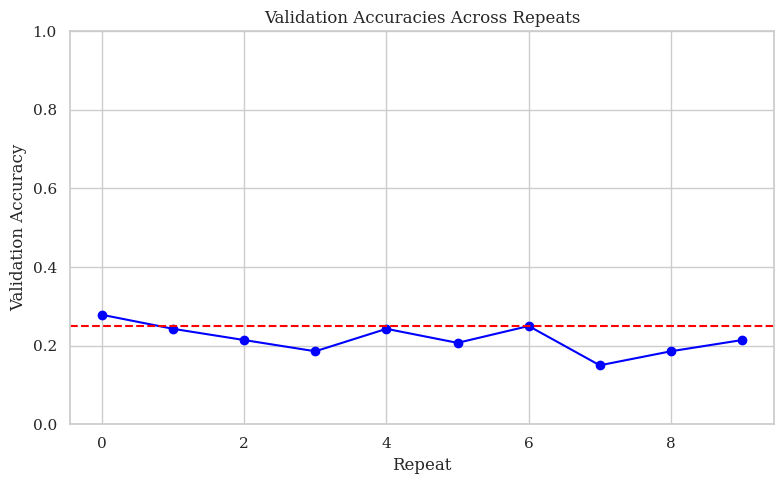

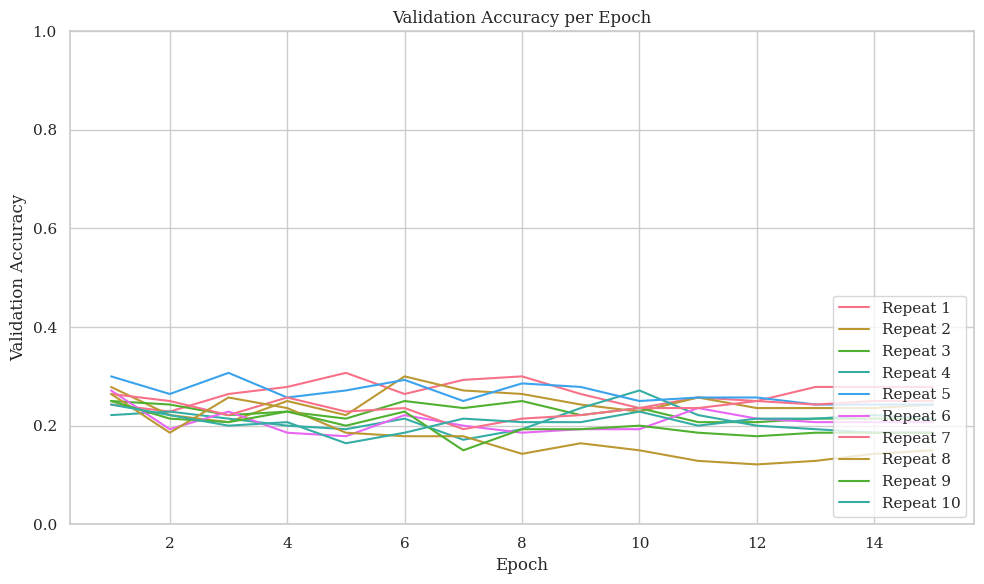

In [22]:
accuracies = results['all_accuracies']
histories = results['all_histories']
epochs = experiment.epochs

# plot validation accuracies across repeats
plt.figure(figsize=(8, 5))
plt.plot(accuracies, marker='o', linestyle='-', color='blue')
plt.axhline(chance_level, color='red', linestyle='--', label='Chance Level (25%)')
plt.title('Validation Accuracies Across Repeats')
plt.xlabel('Repeat')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# plot validation accuracy curves over epochs for each repeat
plt.figure(figsize=(10, 6))
for i, history in enumerate(histories):
    plt.plot(history[:, 'epoch'], history[:, 'valid_accuracy'], label=f'Repeat {i+1}')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
def run_experiments(learning_rate, batch_size, repeats = 10, epochs = 15):
    data_dir = '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/KARAONE'
    dataset = KARAONEDataset(data_dir)
    
    if len(dataset) == 0:
        print("Dataset is empty. Cannot run experiments.")
        return None, None, None
    
    data = np.stack([preprocess_data(x) for x, _ in dataset])
    labels = np.array([y for _, y in dataset])
    
    val_accuracies = []
    epochs_to_best = []
    all_histories = []

    for i in range(repeats):
        print(f"\nRun {i+1}/{repeats}")
        set_random_seeds(seed = 2025 + i, cuda = torch.cuda.is_available())

        data_dir = '/Users/ingerlisamalia/Desktop/NEURO 140/Final Project/KARAONE'
        dataset = KARAONEDataset(data_dir)
        data = np.stack([preprocess_data(x) for x, _ in dataset])
        labels = np.array([y for _, y in dataset])

        X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)

        train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
        valid_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())

        n_classes = 4
        n_chans = X_train.shape[1]
        input_time_length = X_train.shape[2]
        print(input_time_length)

        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length, final_conv_length = 'auto')
        if torch.cuda.is_available():
            model.cuda()

        clf = EEGClassifier(
            model,
            criterion = torch.nn.CrossEntropyLoss,
            optimizer = torch.optim.AdamW,
            optimizer__lr = learning_rate,
            train_split = predefined_split(valid_dataset),
            batch_size = batch_size,
            callbacks = ['accuracy'],
            device = 'cuda' if torch.cuda.is_available() else 'cpu',
            classes = list(range(4))
        )

        clf.fit(train_dataset, y = None, epochs = epochs)

        best_epoch = int(np.argmax(clf.history[:, 'valid_accuracy']))
        best_acc = float(clf.history[best_epoch, 'valid_accuracy'])
        val_accuracies.append(best_acc)
        epochs_to_best.append(best_epoch)
        all_histories.append(clf.history)

    return val_accuracies, epochs_to_best, all_histories


In [16]:
# run training
learning_rate = 0.00075
batch_size = 40

accuracies, epochs_needed, histories = run_experiments(learning_rate, batch_size, repeats = 10)

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar


Run 1/10


/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

1001


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3183        2.7719       0.2500            0.2500        1.8592  3.6983
      2            0.3543        2.2118       0.2429            0.2429        1.8466  3.6810
      3            0.4353        1.9550       0.2714            0.2714        1.5473  3.5271
      4            0.5126        1.6933       0.2857            0.2857        1.6288  3.5219
      5            0.5360        1.6104       0.2500            0.2500        1.5476  3.5530
      6            0.5989        1.4974       0.2786            0.2786        1.5520  3.5582
      7            0.6367        1.3444       0.2857            0.2857        1.6276  3.5509
      8            0.6781        1.3475       0.3000            0.3000        1.5963  3.5406
      9            0.7086        1.3955       0.2500            0.2500

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

1001


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3255        2.5870       0.2786            0.2786        1.9133  3.6666
      2            0.3813        2.1320       0.2714            0.2714        1.7560  3.5554
      3            0.4424        1.9133       0.3143            0.3143        1.6809  3.5330
      4            0.4748        1.6897       0.2571            0.2571        1.6134  3.6331
      5            0.5414        1.6106       0.2000            0.2000        1.6009  3.5668
      6            0.5989        1.4391       0.2571            0.2571        1.6075  3.5717
      7            0.6673        1.3896       0.2214            0.2214        1.5974  3.5460
      8            0.6655        1.3328       0.2571            0.2571        1.6177  3.5530
      9            0.6888        1.3072       0.2857            0.2857

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

1001


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3255        2.6486       0.2643            0.2643        2.8228  3.6933
      2            0.3885        2.0372       0.2143            0.2143        1.8818  3.5638
      3            0.4550        1.8065       0.2143            0.2143        1.6983  3.5179
      4            0.5144        1.6946       0.2571            0.2571        1.5540  3.4996
      5            0.5683        1.5875       0.2429            0.2429        1.6472  3.5205
      6            0.6169        1.3962       0.2286            0.2286        1.6907  3.4985
      7            0.6799        1.4076       0.2071            0.2071        1.6806  3.5102
      8            0.6853        1.3521       0.2143            0.2143        1.6742  3.5343
      9            0.7356        1.2812       0.2357            0.2357

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

1001


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.2590        2.6756       0.2357            0.2357        3.0066  3.6959
      2            0.3507        2.1674       0.2286            0.2286        2.0029  3.5497
      3            0.4550        1.9302       0.3000            0.3000        1.5801  3.5365
      4            0.4820        1.6234       0.2786            0.2786        1.6370  3.6802
      5            0.5881        1.5705       0.2714            0.2714        1.5809  3.5603
      6            0.6169        1.4694       0.2429            0.2429        1.5935  3.5549
      7            0.6547        1.4078       0.2571            0.2571        1.6416  3.4938
      8            0.6673        1.2749       0.2500            0.2500        1.6071  3.5605
      9            0.7068        1.3138       0.2214            0.2214

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

1001


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3147        2.9916       0.2429            0.2429        2.0073  3.6877
      2            0.3705        2.2324       0.2786            0.2786        1.8533  3.5610
      3            0.4155        1.9491       0.2143            0.2143        1.7354  3.5045
      4            0.5018        1.7411       0.2286            0.2286        1.6716  3.5545
      5            0.5522        1.6620       0.2143            0.2143        1.6235  3.5770
      6            0.5881        1.4554       0.2143            0.2143        1.5844  3.5102
      7            0.6637        1.3709       0.2286            0.2286        1.6119  3.5092
      8            0.6601        1.3781       0.2500            0.2500        1.6105  3.6270
      9            0.7068        1.2753       0.2071            0.2071

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

1001


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.2950        2.7180       0.1857            0.1857        2.2018  3.7184
      2            0.3615        2.1759       0.2214            0.2214        1.7740  3.5702
      3            0.4586        1.8888       0.2000            0.2000        1.6270  3.5190
      4            0.5342        1.6632       0.2500            0.2500        1.5789  3.5446
      5            0.5540        1.5288       0.2500            0.2500        1.5813  3.5247
      6            0.5809        1.5078       0.2071            0.2071        1.6290  3.5110
      7            0.6277        1.4565       0.2571            0.2571        1.5401  3.5178
      8            0.6583        1.4003       0.1929            0.1929        1.5699  3.5513
      9            0.7158        1.3287       0.2000            0.2000

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

1001


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.2806        2.8054       0.2143            0.2143        2.0672  3.6355
      2            0.3939        2.2164       0.2357            0.2357        1.8132  3.5046
      3            0.4550        1.9272       0.1929            0.1929        1.7541  3.5258
      4            0.4874        1.8177       0.1929            0.1929        1.8465  3.5138
      5            0.5396        1.6117       0.1786            0.1786        1.8100  3.5129
      6            0.6007        1.5592       0.2357            0.2357        1.7446  3.5508
      7            0.6151        1.3958       0.2214            0.2214        1.6967  3.5118
      8            0.6691        1.4064       0.1857            0.1857        1.7487  3.5456
      9            0.6313        1.2908       0.1857            0.1857

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

1001


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.3129        2.7576       0.2214            0.2214        2.0849  3.6111
      2            0.3921        2.0694       0.2214            0.2214        1.8293  3.4837
      3            0.4622        1.8394       0.1929            0.1929        1.8122  3.6120
      4            0.4586        1.7252       0.1571            0.1571        1.8064  3.5032
      5            0.5504        1.7353       0.1786            0.1786        1.8374  3.6007
      6            0.6079        1.4273       0.2071            0.2071        1.7882  3.7347
      7            0.6277        1.3848       0.1786            0.1786        1.7878  3.5085
      8            0.6511        1.3588       0.1929            0.1929        1.8533  3.5538
      9            0.7032        1.2876       0.1500            0.1500

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

1001


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.2770        2.5873       0.2571            0.2571        2.2141  3.5835
      2            0.3849        2.1807       0.2857            0.2857        1.7934  3.5613
      3            0.3903        1.8615       0.2143            0.2143        1.9641  3.4966
      4            0.4622        1.7466       0.2357            0.2357        1.6278  3.5666
      5            0.5090        1.6253       0.3071            0.3071        1.5747  3.4858
      6            0.5827        1.5496       0.2500            0.2500        1.5545  3.5353
      7            0.6241        1.3825       0.2786            0.2786        1.6462  3.5149
      8            0.6619        1.3153       0.1857            0.1857        1.6364  3.5280
      9            0.6745        1.2386       0.2071            0.2071

/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(cnt_path, preload=True, verbose=False)
/var/folders/s8/qy5wqcgd6ndgkxlmwk_vdyhc0000gn/T/ipykernel_2063/3666276299.py:63: RuntimeWar

1001


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------
      1            0.2932        2.6869       0.2357            0.2357        2.1111  3.5789
      2            0.3705        2.1392       0.2071            0.2071        1.8124  3.5295
      3            0.4550        1.8135       0.1929            0.1929        1.7498  3.5851
      4            0.5288        1.6313       0.2071            0.2071        1.6758  3.5097
      5            0.5737        1.5348       0.1929            0.1929        1.7282  3.5477
      6            0.6349        1.4949       0.1714            0.1714        1.7238  3.5794
      7            0.6205        1.3762       0.1929            0.1929        1.7032  3.4991
      8            0.6547        1.2983       0.1643            0.1643        1.8167  3.5030
      9            0.6745        1.3092       0.2071            0.2071

In [20]:
# run t-tests
chance_level = 0.25
acc_t, acc_p = ttest_1samp(accuracies, chance_level)

print("\nT-test against chance level:")
print(f"Validation Accuracy - t: {acc_t:.4f}, p: {acc_p:.4f}")


T-test against chance level:
Validation Accuracy - t: 2.3041, p: 0.0467


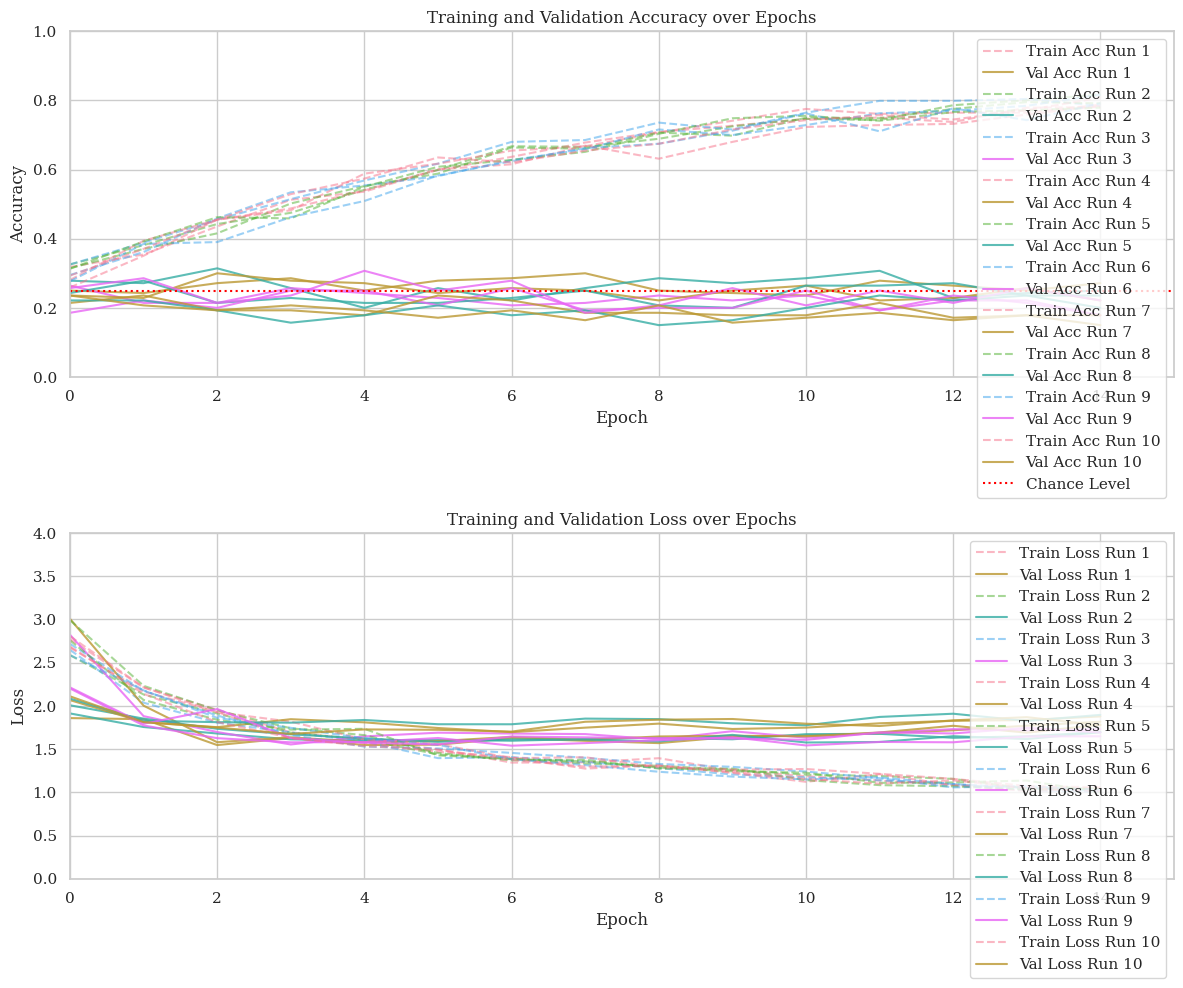

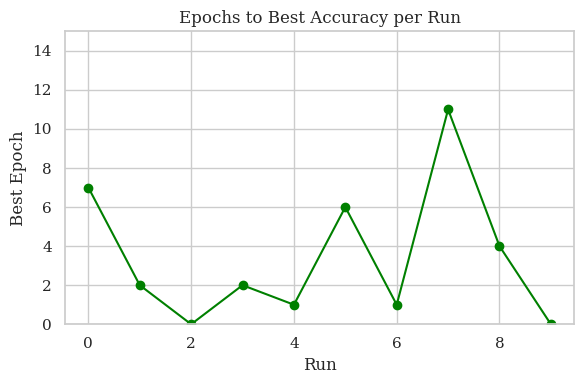

In [19]:
# plot results
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

num_epochs = 15

for i, hist in enumerate(histories):
    axs[0].plot(hist[:, 'train_accuracy'], linestyle='--', alpha=0.5, label=f'Train Acc Run {i + 1}')
    axs[0].plot(hist[:, 'valid_accuracy'], alpha=0.8, label=f'Val Acc Run {i + 1}')
    axs[1].plot(hist[:, 'train_loss'], linestyle='--', alpha=0.5, label=f'Train Loss Run {i + 1}')
    axs[1].plot(hist[:, 'valid_loss'], alpha=0.8, label=f'Val Loss Run {i + 1}')

# plot accuracy per repeat
axs[0].axhline(y=chance_level, color='r', linestyle=':', label='Chance Level')
axs[0].set_title('Training and Validation Accuracy over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, num_epochs)
axs[0].legend()
axs[0].grid(True)

# plot loss per repeat
axs[1].set_title('Training and Validation Loss over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(0, 4)
axs[1].set_xlim(0, num_epochs)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# epochs to best accuracy plot
plt.figure(figsize=(6, 4))
plt.plot(epochs_needed, marker='o', color='green')
plt.title('Epochs to Best Accuracy per Run')
plt.xlabel('Run')
plt.ylabel('Best Epoch')
plt.ylim(0, num_epochs)
plt.grid(True)
plt.tight_layout()
plt.show()